## Uploading the data to Hadoop

In [4]:
!pip install pandas requests hdfs

In [1]:
import requests
import pandas as pd
from hdfs import InsecureClient
from io import StringIO
import time

# HDFS client configuration
hdfs_client = InsecureClient('http://localhost:9870', user='khaleed_mammad')
hdfs_path = '/input/nypd_data/'

# API endpoint
api_url = "https://data.cityofnewyork.us/resource/qgea-i56i.csv"

# Parameters for pagination
limit = 50000  # Maximum rows per request
offset = 0
rows_to_fetch = 8900000 // 8  
rows_fetched = 0


max_retries = 5
retry_delay = 5

chunk_size = 100000  # Rows per chunk

print("Starting data fetch and upload process...\n")

# Fetch and upload the dataset in chunks
while rows_fetched < rows_to_fetch:
    params = {"$limit": limit, "$offset": offset}
    retries = 0

    while retries < max_retries:
        try:
            print(f"Fetching data: Offset={offset}, Limit={limit} (Attempt {retries + 1})...")
            response = requests.get(api_url, params=params, timeout=30)

            if response.status_code != 200:
                print(f"Error {response.status_code}: {response.text}")
                retries += 1
                time.sleep(retry_delay)
                continue

            # Read the chunk into a DataFrame
            chunk = pd.read_csv(StringIO(response.text))
            if chunk.empty:
                print("No more data to fetch. Exiting.")
                break

            rows_fetched += len(chunk)
            offset += limit

            # Upload the chunk to HDFS
            chunk_path = f'/input/nypd_data/NYPD_Complaint_Data_Chunk_{offset//limit}.csv'
            with StringIO() as csv_buffer:
                chunk.to_csv(csv_buffer, index=False)
                hdfs_client.write(chunk_path, csv_buffer.getvalue(), overwrite=True)
            print(f"Uploaded chunk to HDFS: {chunk_path} (Total rows fetched: {rows_fetched})\n")
            break

        except requests.exceptions.Timeout:
            print("Request timed out. Retrying...")
            retries += 1
            time.sleep(retry_delay)

        except Exception as e:
            print(f"An error occurred: {e}")
            retries += 1
            time.sleep(retry_delay)

    if retries == max_retries:
        print(f"Max retries reached for Offset={offset}. Exiting.")
        break

print(f"Process complete. Total rows fetched: {rows_fetched}")

Starting data fetch and upload process...

Fetching data: Offset=0, Limit=50000 (Attempt 1)...



KeyboardInterrupt



## Reading data and analyzing

In [1]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date 
from pyspark.sql.functions import year, month 
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *
import os
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

In [3]:
import os
import pandas as pd

# Define the directory containing the CSV files
directory = '/Users/khaleed_mammad/Desktop/Khaleed/ADA_Semesters/Fall_2024/Big_Data/Project'

# Output file path
output_file = os.path.join(directory, 'NYPD_Complaint_Data_Combined.csv')

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# Check if there are CSV files
if not csv_files:
    print("No CSV files found in the directory.")
else:
    print(f"Found {len(csv_files)} CSV files. Merging now...")

    # Initialize an empty list to hold DataFrames
    dataframes = []

    # Loop through each CSV file and append its DataFrame to the list
    for file in csv_files:
        file_path = os.path.join(directory, file)
        print(f"Reading file: {file}")
        try:
            df = pd.read_csv(file_path)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")

    # Concatenate all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True)

    # Save the combined DataFrame to a new CSV file
    combined_df.to_csv(output_file, index=False)
    print(f"All files merged successfully into: {output_file}")

Found 23 CSV files. Merging now...
Reading file: NYPD_Complaint_Data_Chunk_10.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_11.csv
Reading file: NYPD_Complaint_Data_Chunk_13.csv
Reading file: NYPD_Complaint_Data_Chunk_12.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_16.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_17.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_15.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_14.csv
Reading file: NYPD_Complaint_Data_Chunk_5.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_4.csv
Reading file: NYPD_Complaint_Data_Chunk_6.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_7.csv
Reading file: NYPD_Complaint_Data_Chunk_3.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_2.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_1.csv
Reading file: NYPD_Complaint_Data_Chunk_9.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_8.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_19.csv
Reading file: NYPD_Complaint_Data_Chunk_18.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_23.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_22.csv


/var/folders/l8/v1sknhls4s34d0r6p0v084fh0000gn/T/ipykernel_66434/2404809267.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Reading file: NYPD_Complaint_Data_Chunk_20.csv
Reading file: NYPD_Complaint_Data_Chunk_21.csv
All files merged successfully into: /Users/khaleed_mammad/Desktop/Khaleed/ADA_Semesters/Fall_2024/Big_Data/Project/NYPD_Complaint_Data_Combined.csv


In [30]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYPD Data Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Path to the local combined CSV file
local_csv_path = output_file

# Read the CSV file into a DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").csv(local_csv_path)

In [31]:
# Show the first 5 rows
df.show(5)

+----------+-------------------+-------------------+-------------------+------------+-----------+-------------------+-----+--------------------+-----+--------------------+----------------+-----------+-------------+-----------------+--------------------+-------------------+-----------------+--------+----------+-----------+----------+----------+--------------+--------------+--------+----------------+---------+----------+--------------------+--------------------+------------+-------------+--------+-------+
|cmplnt_num|       cmplnt_fr_dt|       cmplnt_fr_tm|       cmplnt_to_dt|cmplnt_to_tm|addr_pct_cd|             rpt_dt|ky_cd|           ofns_desc|pd_cd|             pd_desc|crm_atpt_cptd_cd| law_cat_cd|      boro_nm|loc_of_occur_desc|       prem_typ_desc|         juris_desc|jurisdiction_code|parks_nm|hadevelopt|housing_psa|x_coord_cd|y_coord_cd|susp_age_group|     susp_race|susp_sex|transit_district| latitude| longitude|             lat_lon|         patrol_boro|station_name|vic_age_group|

In [33]:
df.first()

Row(cmplnt_num='265088253', cmplnt_fr_dt=datetime.datetime(2023, 2, 9, 0, 0), cmplnt_fr_tm=datetime.datetime(2024, 11, 22, 15, 0), cmplnt_to_dt=datetime.datetime(2023, 3, 9, 0, 0), cmplnt_to_tm='15:00:00', addr_pct_cd=26.0, rpt_dt=datetime.datetime(2023, 3, 14, 0, 0), ky_cd=109, ofns_desc='GRAND LARCENY', pd_cd=439.0, pd_desc='LARCENY,GRAND FROM OPEN AREAS, UNATTENDED', crm_atpt_cptd_cd='COMPLETED', law_cat_cd='FELONY', boro_nm='MANHATTAN', loc_of_occur_desc='FRONT OF', prem_typ_desc='MAILBOX INSIDE', juris_desc='N.Y. POLICE DEPT', jurisdiction_code=0, parks_nm='(null)', hadevelopt='(null)', housing_psa='(null)', x_coord_cd=995804.0, y_coord_cd=235548.0, susp_age_group='UNKNOWN', susp_race='UNKNOWN', susp_sex='U', transit_district=None, latitude=40.813196, longitude=-73.958257, lat_lon='(40.813196, -73.958257)', patrol_boro='PATROL BORO MAN NORTH', station_name='(null)', vic_age_group='65+', vic_race='WHITE', vic_sex='M')

In [34]:
# Print the schema
df.printSchema()

root
 |-- cmplnt_num: string (nullable = true)
 |-- cmplnt_fr_dt: timestamp (nullable = true)
 |-- cmplnt_fr_tm: timestamp (nullable = true)
 |-- cmplnt_to_dt: timestamp (nullable = true)
 |-- cmplnt_to_tm: string (nullable = true)
 |-- addr_pct_cd: double (nullable = true)
 |-- rpt_dt: timestamp (nullable = true)
 |-- ky_cd: integer (nullable = true)
 |-- ofns_desc: string (nullable = true)
 |-- pd_cd: double (nullable = true)
 |-- pd_desc: string (nullable = true)
 |-- crm_atpt_cptd_cd: string (nullable = true)
 |-- law_cat_cd: string (nullable = true)
 |-- boro_nm: string (nullable = true)
 |-- loc_of_occur_desc: string (nullable = true)
 |-- prem_typ_desc: string (nullable = true)
 |-- juris_desc: string (nullable = true)
 |-- jurisdiction_code: integer (nullable = true)
 |-- parks_nm: string (nullable = true)
 |-- hadevelopt: string (nullable = true)
 |-- housing_psa: string (nullable = true)
 |-- x_coord_cd: double (nullable = true)
 |-- y_coord_cd: double (nullable = true)
 |-- 

In [35]:
df.describe()

DataFrame[summary: string, cmplnt_num: string, cmplnt_to_tm: string, addr_pct_cd: string, ky_cd: string, ofns_desc: string, pd_cd: string, pd_desc: string, crm_atpt_cptd_cd: string, law_cat_cd: string, boro_nm: string, loc_of_occur_desc: string, prem_typ_desc: string, juris_desc: string, jurisdiction_code: string, parks_nm: string, hadevelopt: string, housing_psa: string, x_coord_cd: string, y_coord_cd: string, susp_age_group: string, susp_race: string, susp_sex: string, transit_district: string, latitude: string, longitude: string, lat_lon: string, patrol_boro: string, station_name: string, vic_age_group: string, vic_race: string, vic_sex: string]

In [36]:
df.columns

['cmplnt_num',
 'cmplnt_fr_dt',
 'cmplnt_fr_tm',
 'cmplnt_to_dt',
 'cmplnt_to_tm',
 'addr_pct_cd',
 'rpt_dt',
 'ky_cd',
 'ofns_desc',
 'pd_cd',
 'pd_desc',
 'crm_atpt_cptd_cd',
 'law_cat_cd',
 'boro_nm',
 'loc_of_occur_desc',
 'prem_typ_desc',
 'juris_desc',
 'jurisdiction_code',
 'parks_nm',
 'hadevelopt',
 'housing_psa',
 'x_coord_cd',
 'y_coord_cd',
 'susp_age_group',
 'susp_race',
 'susp_sex',
 'transit_district',
 'latitude',
 'longitude',
 'lat_lon',
 'patrol_boro',
 'station_name',
 'vic_age_group',
 'vic_race',
 'vic_sex']

## Data Cleaning & Preprocessing

In [39]:
df.select("cmplnt_fr_dt").show(5)

+-------------------+
|       cmplnt_fr_dt|
+-------------------+
|2023-02-09 00:00:00|
|2023-03-14 00:00:00|
|2023-03-14 00:00:00|
|2023-03-14 00:00:00|
|2023-03-14 00:00:00|
+-------------------+
only showing top 5 rows



In [40]:
# Firstly, we create columns to store 'Year, month, hour and day of the week' of start date of complaint
df = df.withColumn('Start_Date', to_timestamp('cmplnt_fr_dt', 'MM/dd/yyyy'))
df = df.withColumn('Date', to_date('Start_Date'))
df = df.withColumn('Hour', hour(df['cmplnt_fr_tm']))
df = df.withColumn('YEAR', year('Date')) 
df = df.withColumn('MONTH', month('Date'))
df = df.withColumn("DAY_of_WEEK", date_format("Date", "E"))

In [47]:
df.groupBy('vic_age_group').count().show()

+-------------+------+
|vic_age_group| count|
+-------------+------+
|          <18| 43353|
|        25-44|409647|
|      UNKNOWN|326170|
|         1018|     2|
|          -49|     1|
|          949|     1|
|          65+| 58291|
|         -968|     1|
|        18-24| 95680|
|          -33|     1|
|           -3|     2|
|        45-64|216793|
|           -2|     3|
|          -30|     3|
|           -6|     2|
|          -57|     1|
|          950|     1|
|         -945|     1|
|         -963|     1|
|          -27|     1|
+-------------+------+
only showing top 20 rows



In [ ]:
# We can categorize age groups --> Teenager, Young Adult, Middle Age, Mid Old
df1 = df1.withColumn('VIC_AGE_Cat',
    when(df1.VIC_AGE_GROUP == '<18', 'Teenager')
    .when(df1.VIC_AGE_GROUP == '18-25', 'Young Adult')
    .when(df1.VIC_AGE_GROUP == '25-44', 'Middle Age')
    .when(df1.VIC_AGE_GROUP == '44-64', 'Mid Old')
    .otherwise('Senior'))

In [48]:
from pyspark.sql.functions import when

# We can categorize age groups --> Teenager, Young Adult, Middle Age, Mid Old and Senior

# As UNKNOWN occurs 326170 times, we replace it with mode instead of instead of deleting (but we delete invalid ages)

mode_value = (
    df.filter(df["vic_age_group"] != "UNKNOWN")
    .groupBy("vic_age_group")
    .agg(count("*").alias("count"))
    .orderBy(col("count").desc())
    .first()["vic_age_group"]  # Get the value of the most frequent category
)

df = df.withColumn(
    "vic_age_group",
    when(df["vic_age_group"] == "UNKNOWN", mode_value)  # Replace UNKNOWN with mode
    .when(df["vic_age_group"].isin("<18", "18-24", "25-44", "45-64", "65+"), df["vic_age_group"])  # Keep valid categories
    .otherwise(None)  # Mark invalid values as NULL for removal
)

df = df.filter(df["vic_age_group"].isNotNull())

# Now, we can categorize
df = df.withColumn(
    "vic_age_category",
    when(df["vic_age_group"] == "<18", "Teenager")
    .when(df["vic_age_group"] == "18-24", "Young Adult")
    .when(df["vic_age_group"] == "25-44", "Middle Age")
    .when(df["vic_age_group"] == "45-64", "Mid Old")
    .when(df["vic_age_group"] == "65+", "Senior")
)

In [49]:
df.groupBy('vic_age_group').count().show()

+-------------+------+
|vic_age_group| count|
+-------------+------+
|          <18| 43353|
|        25-44|735817|
|          65+| 58291|
|        18-24| 95680|
|        45-64|216793|
+-------------+------+



In [50]:
df.groupBy('vic_age_category').count().show()

+----------------+------+
|vic_age_category| count|
+----------------+------+
|          Senior| 58291|
|        Teenager| 43353|
|      Middle Age|735817|
|     Young Adult| 95680|
|         Mid Old|216793|
+----------------+------+



In [73]:
# We need to drop some irrelevant and redundant columns (some are too specific and some of them have too many null values)
dataset = df.drop('cmplnt_num','cmplnt_fr_dt', 'cmplnt_fr_tm', 'cmplnt_to_dt', 'cmplnt_to_tm','pd_cd','rpt_dt',
                 'pd_desc','loc_of_occur_desc', 'prem_typ_desc', 'juris_desc', 'jurisdiction_code', 'parks_nm',
                  'hadevelopt', 'housing_psa','x_coord_cd','y_coord_cd','susp_age_group','susp_race', 
                  'susp_sex', 'transit_district','patrol_boro','station_name','vic_age_group','vic_race', 'Start_Date')

In [74]:
dataset.show(1)

+-----------+-----+-------------+----------------+----------+---------+---------+----------+--------------------+-------+----------+----+----+-----+-----------+----------------+
|addr_pct_cd|ky_cd|    ofns_desc|crm_atpt_cptd_cd|law_cat_cd|  boro_nm| latitude| longitude|             lat_lon|vic_sex|      Date|Hour|YEAR|MONTH|DAY_of_WEEK|vic_age_category|
+-----------+-----+-------------+----------------+----------+---------+---------+----------+--------------------+-------+----------+----+----+-----+-----------+----------------+
|       26.0|  109|GRAND LARCENY|       COMPLETED|    FELONY|MANHATTAN|40.813196|-73.958257|(40.813196, -73.9...|      M|2023-02-09|  15|2023|    2|        Thu|          Senior|
+-----------+-----+-------------+----------------+----------+---------+---------+----------+--------------------+-------+----------+----+----+-----+-----------+----------------+
only showing top 1 row



In [75]:
#Renaming the columns for better readabiliy

dataframe = dataset.toDF('Neighborhood', 'Offence_Code', 'Offence_Type',
        'Status','Offence_Level','Borough','Latitude','Longitude','Lat_Lon', 'Victim_Sex', 'Date', 'Hour', 'Year', 'Month', 'Day_of_Week','Victim_Agegroup')



In [76]:
# We also handle with null values

mean_long = dataframe.agg({'Longitude': 'mean'}).collect()[0][0] 
dataframe = dataframe.fillna(mean_long, subset=['Longitude'])

mean_lat = dataframe.agg({'Latitude': 'mean'}).collect()[0][0] 
dataframe = dataframe.fillna(mean_lat, subset=['Latitude'])

dataframe = dataframe.fillna(-1, subset=['Borough','Neighborhood','Offence_Code','Offence_Type','Status','Offence_level','Victim_Sex'])
dataframe = dataframe.na.drop('any')

In [77]:
print(f"Previous dataset: {df.count()} rows \nNew dataset: {dataframe.count()} rows")

Previous dataset: 1149934 rows 
New dataset: 1149919 rows


In [90]:
# We save the dataset
dataframe.write.csv("cleaned_nypd_data.csv", header=True, mode='overwrite')

## Analysis with SQL

In [60]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYPD Data Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .enableHiveSupport() \
    .getOrCreate()

24/12/09 13:12:57 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [61]:
cleaned_data = spark.read.csv("cleaned_nypd_data.csv", header=True, inferSchema=True)
cleaned_data.printSchema()

root
 |-- Neighborhood: double (nullable = true)
 |-- Offence_Code: integer (nullable = true)
 |-- Offence_Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Offence_Level: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Lat_Lon: string (nullable = true)
 |-- Victim_Sex: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Victim_Agegroup: string (nullable = true)



In [63]:
spark.sql("create database nypddatabase");

In [64]:
# spark.conf.set("spark.sql.parquet.datetimeRebaseModeInWrite", "LEGACY")
spark.sql("USE nypddatabase")
cleaned_data.write.mode("overwrite").saveAsTable("df")

In [66]:
# Create a temporary view
cleaned_data.createOrReplaceTempView("nypd_data")

In [65]:
spark.sql("SHOW TABLES").show()

+------------+---------+-----------+
|   namespace|tableName|isTemporary|
+------------+---------+-----------+
|nypddatabase|       df|      false|
|            |nypd_data|       true|
+------------+---------+-----------+



### Overview Queries

In [67]:
total_records = spark.sql("""
    SELECT COUNT(*) AS total_records FROM df
""")
total_records.show()

+-------------+
|total_records|
+-------------+
|      1149919|
+-------------+



In [68]:
# Query
borough_count = spark.sql("""
    SELECT Borough, COUNT(*) AS count
    FROM df
    GROUP BY Borough
    ORDER BY count DESC
""")
borough_count.show()

+-------------+------+
|      Borough| count|
+-------------+------+
|     BROOKLYN|319820|
|    MANHATTAN|280934|
|       QUEENS|251879|
|        BRONX|244984|
|STATEN ISLAND| 50043|
|       (null)|  2259|
+-------------+------+



In [69]:
# We have null values, we can remove them
cleaned_data = cleaned_data.filter(cleaned_data["Borough"].isin('BROOKLYN', 'MANHATTAN', 'QUEENS', 'BRONX', 'STATEN ISLAND'))
cleaned_data.write.mode("overwrite").saveAsTable("df")

In [70]:
# Query
borough_count = spark.sql("""
    SELECT Borough, COUNT(*) AS count
    FROM df
    GROUP BY Borough
    ORDER BY count DESC
""")
borough_count.show()

+-------------+------+
|      Borough| count|
+-------------+------+
|     BROOKLYN|319820|
|    MANHATTAN|280934|
|       QUEENS|251879|
|        BRONX|244984|
|STATEN ISLAND| 50043|
+-------------+------+



In [71]:
# Query
offence_type_distribution = spark.sql("""
    SELECT Offence_Type, COUNT(*) AS count
    FROM df
    GROUP BY Offence_Type
    ORDER BY count DESC
""")
offence_type_distribution.show()

+--------------------+------+
|        Offence_Type| count|
+--------------------+------+
|       PETIT LARCENY|236696|
|       HARRASSMENT 2|176681|
|ASSAULT 3 & RELAT...|119670|
|       GRAND LARCENY|110396|
|CRIMINAL MISCHIEF...| 92419|
|      FELONY ASSAULT| 56915|
|OFF. AGNST PUB OR...| 38685|
|VEHICLE AND TRAFF...| 37389|
|             ROBBERY| 36437|
|MISCELLANEOUS PEN...| 35139|
|            BURGLARY| 31688|
|GRAND LARCENY OF ...| 31077|
|     DANGEROUS DRUGS| 22483|
|          SEX CRIMES| 18084|
|   DANGEROUS WEAPONS| 15627|
|OFFENSES AGAINST ...| 14447|
|             FORGERY| 11989|
|         THEFT-FRAUD|  7964|
|OFFENSES INVOLVIN...|  6807|
|INTOXICATED & IMP...|  6592|
+--------------------+------+
only showing top 20 rows



In [72]:
result_df = spark.sql(("""
    SELECT Offence_Level, COUNT(*) AS Count 
    FROM nypddatabase.df 
    GROUP BY Offence_Level
    """))
                      
result_df.show()

+-------------+------+
|Offence_Level| Count|
+-------------+------+
|       FELONY|388236|
|  MISDEMEANOR|579643|
|    VIOLATION|179781|
+-------------+------+



In [73]:
# Query
status_distribution = spark.sql("""
    SELECT Status, COUNT(*) AS count
    FROM df
    GROUP BY Status
    ORDER BY count DESC
""")
status_distribution.show()

+---------+-------+
|   Status|  count|
+---------+-------+
|COMPLETED|1130934|
|ATTEMPTED|  16726|
+---------+-------+



### Analysis

In [74]:
result_df = spark.sql(("""
    SELECT Offence_Level,Victim_Sex,  COUNT(*) AS Count 
    FROM nypddatabase.df 
    GROUP BY Offence_Level,Victim_Sex
    """))
                      
result_df.show()

+-------------+----------+------+
|Offence_Level|Victim_Sex| Count|
+-------------+----------+------+
|  MISDEMEANOR|         D|138374|
|  MISDEMEANOR|         M|180082|
|       FELONY|         M|154396|
|       FELONY|         L|  4248|
|       FELONY|         D| 55341|
|    VIOLATION|         D|  1650|
|       FELONY|         F|133412|
|  MISDEMEANOR|         L|  1613|
|    VIOLATION|         F|112422|
|       FELONY|         E| 40838|
|    VIOLATION|         L|   197|
|  MISDEMEANOR|         F|194506|
|  MISDEMEANOR|         E| 65068|
|    VIOLATION|         E|  2059|
|    VIOLATION|         M| 63453|
|       FELONY|         U|     1|
+-------------+----------+------+



In [75]:
# Seems like we have some errors in sex column

In [76]:
result_df = spark.sql(("""
    SELECT Victim_Sex,  COUNT(*) AS Count 
    FROM nypddatabase.df 
    GROUP BY Victim_Sex
    ORDER BY Count
    """))
                      
result_df.show()

+----------+------+
|Victim_Sex| Count|
+----------+------+
|         U|     1|
|         L|  6058|
|         E|107965|
|         D|195365|
|         M|397931|
|         F|440340|
+----------+------+



In [77]:
# Dropping U, L, E , D would cause a problem as they contain big protion of our data. Therefore, 
# we decide to keep it since our purpose is not studying crime patterns by gender

In [78]:
result_df = spark.sql(("""
    SELECT Year, COUNT(*) AS Count 
    FROM nypddatabase.df 
    GROUP BY Year
    ORDER BY Year
    """))
                      
result_df.show()

+----+-----+
|Year|Count|
+----+-----+
|1011|    3|
|1012|    6|
|1013|    2|
|1018|    1|
|1021|    2|
|1022|   11|
|1023|   23|
|1900|    1|
|1921|    2|
|1922|    7|
|1923|    5|
|1949|    1|
|1955|    1|
|1961|    1|
|1964|    1|
|1966|    1|
|1967|    1|
|1969|    1|
|1970|    1|
|1971|    2|
+----+-----+
only showing top 20 rows



In [79]:
# Seems like we have errors in year column


In [80]:
result_df = spark.sql(("""
    SELECT Year, COUNT(*) AS Count 
    FROM nypddatabase.df 
    GROUP BY Year
    ORDER BY Year DESC
    """))
                      
result_df.show()

+----+------+
|Year| Count|
+----+------+
|2023|542304|
|2022|528717|
|2021| 71748|
|2020|  1546|
|2019|   686|
|2018|   438|
|2017|   304|
|2016|   243|
|2015|   215|
|2014|   186|
|2013|   189|
|2012|   140|
|2011|   132|
|2010|    68|
|2009|    47|
|2008|    41|
|2007|    52|
|2006|    41|
|2005|    28|
|2004|    28|
+----+------+
only showing top 20 rows



In [82]:
# Since most of data smaples belong to the years "2023", "2022", "2021" and "2020", we only keep those.
cleaned_data = cleaned_data.filter(cleaned_data["Year"].isin(2023, 2022, 2021, 2020))
cleaned_data.write.mode("overwrite").saveAsTable("df")

In [83]:
# Query
offences_per_month = spark.sql("""
    SELECT Month, COUNT(*) AS count
    FROM df
    GROUP BY Month
    ORDER BY count DESC
""")
offences_per_month.show()

+-----+------+
|Month| count|
+-----+------+
|   12|124920|
|   11|112746|
|    7| 96582|
|   10| 96200|
|    8| 95424|
|    6| 95044|
|    5| 94922|
|    9| 91334|
|    3| 88998|
|    4| 87050|
|    1| 83674|
|    2| 77421|
+-----+------+



In [84]:
# Query
offences_per_day = spark.sql("""
    SELECT Day_of_Week, COUNT(*) AS count
    FROM df
    GROUP BY Day_of_Week
    ORDER BY count DESC
""")
offences_per_day.show()

+-----------+------+
|Day_of_Week| count|
+-----------+------+
|        Fri|172032|
|        Wed|170882|
|        Thu|166517|
|        Tue|165789|
|        Sat|159516|
|        Mon|158996|
|        Sun|150583|
+-----------+------+



In [85]:
# Query
offences_by_hour = spark.sql("""
    SELECT Hour, COUNT(*) AS count
    FROM df
    GROUP BY Hour
    ORDER BY count DESC
""")
offences_by_hour.show()

+----+-----+
|Hour|count|
+----+-----+
|  17|69816|
|  15|69060|
|  18|68168|
|  16|67833|
|  12|66067|
|  19|64659|
|  14|61797|
|  20|61592|
|  13|56167|
|  21|54421|
|  11|50699|
|  22|49488|
|   0|49414|
|  10|49166|
|   9|45434|
|  23|43103|
|   8|43100|
|   1|34173|
|   2|28889|
|   7|28332|
+----+-----+
only showing top 20 rows



### Demographics Analysis

In [86]:
# Query
victim_agegroup_distribution = spark.sql("""
    SELECT Victim_Agegroup, COUNT(*) AS count
    FROM df
    GROUP BY Victim_Agegroup
    ORDER BY count DESC
""")
victim_agegroup_distribution.show()

+---------------+------+
|Victim_Agegroup| count|
+---------------+------+
|     Middle Age|732887|
|        Mid Old|216110|
|    Young Adult| 94895|
|         Senior| 58087|
|       Teenager| 42336|
+---------------+------+



In [87]:
# Query
victim_sex_distribution = spark.sql("""
    SELECT Victim_Sex, COUNT(*) AS count
    FROM df
    GROUP BY Victim_Sex
    ORDER BY count DESC
""")
victim_sex_distribution.show()

+----------+------+
|Victim_Sex| count|
+----------+------+
|         F|438158|
|         M|397152|
|         D|195194|
|         E|107753|
|         L|  6058|
+----------+------+



In [88]:
# Query
demographics_offence_correlation = spark.sql("""
    SELECT Victim_Agegroup, Victim_Sex, Offence_Type, COUNT(*) AS count
    FROM df
    GROUP BY Victim_Agegroup, Victim_Sex, Offence_Type
    ORDER BY Victim_Agegroup, Victim_Sex, count DESC
""")
demographics_offence_correlation.show()

+---------------+----------+--------------------+-----+
|Victim_Agegroup|Victim_Sex|        Offence_Type|count|
+---------------+----------+--------------------+-----+
|        Mid Old|         D|       PETIT LARCENY|   94|
|        Mid Old|         D|       GRAND LARCENY|   14|
|        Mid Old|         D|CRIMINAL MISCHIEF...|   12|
|        Mid Old|         D|            BURGLARY|   10|
|        Mid Old|         D|             ROBBERY|    3|
|        Mid Old|         F|       HARRASSMENT 2|29928|
|        Mid Old|         F|       PETIT LARCENY|14811|
|        Mid Old|         F|ASSAULT 3 & RELAT...|11623|
|        Mid Old|         F|       GRAND LARCENY|11534|
|        Mid Old|         F|CRIMINAL MISCHIEF...| 8992|
|        Mid Old|         F|OFF. AGNST PUB OR...| 4605|
|        Mid Old|         F|MISCELLANEOUS PEN...| 4367|
|        Mid Old|         F|      FELONY ASSAULT| 3666|
|        Mid Old|         F|GRAND LARCENY OF ...| 2539|
|        Mid Old|         F|            BURGLARY

In [89]:
result_df = spark.sql(("""
    SELECT Offence_Level,Year,  COUNT(*) AS Count 
    FROM nypddatabase.df 
    GROUP BY Offence_Level,Year
    """))
                      
result_df.show()

+-------------+----+------+
|Offence_Level|Year| Count|
+-------------+----+------+
|    VIOLATION|2021| 10648|
|       FELONY|2022|177119|
|  MISDEMEANOR|2021| 33790|
|       FELONY|2021| 27310|
|  MISDEMEANOR|2022|267665|
|    VIOLATION|2020|   128|
|  MISDEMEANOR|2023|276393|
|       FELONY|2020|   831|
|    VIOLATION|2023| 84875|
|       FELONY|2023|181036|
|  MISDEMEANOR|2020|   587|
|    VIOLATION|2022| 83933|
+-------------+----+------+



### Fairness Assessment Queries

In [90]:
# Query
sex_offencelevel_distribution = spark.sql("""
    SELECT Victim_Sex, Offence_Level, COUNT(*) AS count
    FROM df
    GROUP BY Victim_Sex, Offence_Level
    ORDER BY Victim_Sex, Offence_Level DESC
""")
sex_offencelevel_distribution.show()

+----------+-------------+------+
|Victim_Sex|Offence_Level| count|
+----------+-------------+------+
|         D|    VIOLATION|  1648|
|         D|  MISDEMEANOR|138308|
|         D|       FELONY| 55238|
|         E|    VIOLATION|  2059|
|         E|  MISDEMEANOR| 65051|
|         E|       FELONY| 40643|
|         F|    VIOLATION|112287|
|         F|  MISDEMEANOR|193664|
|         F|       FELONY|132207|
|         L|    VIOLATION|   197|
|         L|  MISDEMEANOR|  1613|
|         L|       FELONY|  4248|
|         M|    VIOLATION| 63393|
|         M|  MISDEMEANOR|179799|
|         M|       FELONY|153960|
+----------+-------------+------+



In [91]:
# Query
agegroup_borough_distribution = spark.sql("""
    SELECT Borough, Victim_Agegroup, COUNT(*) AS count
    FROM df
    GROUP BY Borough, Victim_Agegroup
    ORDER BY Borough, Victim_Agegroup DESC
""")
agegroup_borough_distribution.show()

+---------+---------------+------+
|  Borough|Victim_Agegroup| count|
+---------+---------------+------+
|    BRONX|    Young Adult| 21338|
|    BRONX|       Teenager| 10749|
|    BRONX|         Senior| 10653|
|    BRONX|     Middle Age|153115|
|    BRONX|        Mid Old| 48392|
| BROOKLYN|    Young Adult| 26857|
| BROOKLYN|       Teenager| 12261|
| BROOKLYN|         Senior| 16274|
| BROOKLYN|     Middle Age|201673|
| BROOKLYN|        Mid Old| 61795|
|MANHATTAN|    Young Adult| 22821|
|MANHATTAN|       Teenager|  6570|
|MANHATTAN|         Senior| 13225|
|MANHATTAN|     Middle Age|194585|
|MANHATTAN|        Mid Old| 43024|
|   QUEENS|    Young Adult| 19970|
|   QUEENS|       Teenager| 10355|
|   QUEENS|         Senior| 14642|
|   QUEENS|     Middle Age|153917|
|   QUEENS|        Mid Old| 52193|
+---------+---------------+------+
only showing top 20 rows



In [92]:
# Query
demographics_status_correlation = spark.sql("""
    SELECT Victim_Sex, Victim_Agegroup, Status, COUNT(*) AS count
    FROM df
    GROUP BY Victim_Sex, Victim_Agegroup, Status
    ORDER BY Victim_Sex, Victim_Agegroup, Status DESC
""")
demographics_status_correlation.show()

+----------+---------------+---------+------+
|Victim_Sex|Victim_Agegroup|   Status| count|
+----------+---------------+---------+------+
|         D|        Mid Old|COMPLETED|   133|
|         D|     Middle Age|COMPLETED|191654|
|         D|     Middle Age|ATTEMPTED|  2360|
|         D|         Senior|COMPLETED|    15|
|         D|         Senior|ATTEMPTED|     1|
|         D|    Young Adult|COMPLETED|  1031|
|         E|     Middle Age|COMPLETED|106786|
|         E|     Middle Age|ATTEMPTED|   964|
|         E|         Senior|COMPLETED|     1|
|         E|       Teenager|COMPLETED|     1|
|         E|    Young Adult|COMPLETED|     1|
|         F|        Mid Old|COMPLETED|102254|
|         F|        Mid Old|ATTEMPTED|  1350|
|         F|     Middle Age|COMPLETED|225105|
|         F|     Middle Age|ATTEMPTED|  2620|
|         F|         Senior|COMPLETED| 28609|
|         F|         Senior|ATTEMPTED|   461|
|         F|       Teenager|COMPLETED| 23283|
|         F|       Teenager|ATTEMP

In [93]:
total_records = spark.sql("""
    SELECT COUNT(*) AS total_records FROM df
""")
total_records.show()

+-------------+
|total_records|
+-------------+
|      1144315|
+-------------+



In [73]:
cleaned_data.write.csv("ready_data.csv", header=True, mode='overwrite')

# Machine Learning

In [32]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYPD Offence Level Prediction") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

In [33]:
final_data = spark.read.csv("Git_version/ready_data.csv", header=True, inferSchema=True)

In [34]:
final_data.count()

1146573

In [42]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [36]:
str_featues = []
num_features = []

for feature in final_data.dtypes:
    
    # print unique value and data type for each feature
    feature_name = str(feature[0])
    feature_type = str(feature[1])
    uni = final_data.select(feature_name).distinct().count()
    print("unique number of {} ({}):".format(feature_name, feature_type),uni)
    
    # find out features with integer type
    if feature_type == "int" or feature_type == "decimal(65,0)":
        
        num_features.append(feature_name)
        
    # find out string feature and it's unique value less than 70
    elif feature_type == "string" and uni < 70:
        
        str_featues.append(feature_name)

unique number of Neighborhood (double): 78


unique number of Offence_Code (int): 69


unique number of Offence_Type (string): 66


unique number of Status (string): 2


unique number of Offence_Level (string): 3


unique number of Borough (string): 6


unique number of Latitude (double): 96433


unique number of Longitude (double): 97259


unique number of Lat_Lon (string): 102112


unique number of Victim_Sex (string): 5


unique number of Date (date): 1442


unique number of Hour (int): 24


unique number of Year (int): 4


unique number of Month (int): 12


unique number of Day_of_Week (string): 7
unique number of Victim_Agegroup (string): 5


In [37]:
print("Total {} numerical features:{}".format(len(num_features),num_features)) 
print("Total {} string features:{}".format(len(str_featues),str_featues)) 

Total 4 numerical features:['Offence_Code', 'Hour', 'Year', 'Month']
Total 7 string features:['Offence_Type', 'Status', 'Offence_Level', 'Borough', 'Victim_Sex', 'Day_of_Week', 'Victim_Agegroup']


In [38]:
from pyspark.sql.functions import col

# Check for missing values in numerical features
for col_name in num_features:
    missing_count = final_data.filter(col(col_name).isNull()).count()
    print(f"Missing values in {col_name}: {missing_count}")

# Check for missing values in categorical features
for col_name in categorical_columns:
    missing_count = final_data.filter(col(col_name).isNull()).count()
    print(f"Missing values in {col_name}: {missing_count}")


Missing values in Offence_Code: 0
Missing values in Hour: 0
Missing values in Year: 0
Missing values in Month: 0
Missing values in Offence_Type: 0
Missing values in Status: 0
Missing values in Offence_Level: 0
Missing values in Borough: 0
Missing values in Victim_Sex: 0
Missing values in Day_of_Week: 0
Missing values in Victim_Agegroup: 0


In [39]:
# Count total records
total_records = final_data.count()

# Count distinct records
distinct_records = final_data.dropDuplicates().count()

print(f"Total Records: {total_records}")
print(f"Distinct Records: {distinct_records}")

Total Records: 1146573
Distinct Records: 1128427


In [40]:
final_data = final_data.dropDuplicates()

In [41]:
# Count total records
total_records = final_data.count()

# Count distinct records
distinct_records = final_data.dropDuplicates().count()

print(f"Total Records: {total_records}")
print(f"Distinct Records: {distinct_records}")

Total Records: 1128427
Distinct Records: 1128427


In [43]:
# We convert categorical string features into numerical indices:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in str_featues]

In [44]:
# We need to prepare a feature vector for machine learning in PySpark
inputs = ["{}_index".format(x) for x in str_featues] + num_features
feature_vector = VectorAssembler(inputCols= list(set(inputs) - set(['Offence_Level_index'])), outputCol="features")

In [45]:
# Then, we create a PySpark ML Pipeline to preprocess the data and apply transformations systematically
pipeline = Pipeline(stages=indexers + [feature_vector])
data = pipeline.fit(final_data).transform(final_data)

In [46]:
input_data = data.select(["features","Offence_Level_index"])
input_data = input_data.withColumnRenamed("Offence_Level_index","label")

In [47]:
# And, we divide our data into 0.7 train, 0.3 test
train_data, test_data = input_data.randomSplit([.7,.3])

## Logistic Regression

In [48]:
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

In [50]:
lg_model = LogisticRegression(
    labelCol='label',
    featuresCol='features',
    maxIter=100,  
    elasticNetParam=0,
    regParam=0.1,       
    family='multinomial'
)

lg_model = lg_model.fit(train_data)

# Make predictions
lg_pred = lg_model.transform(test_data)

# Evaluate the model
acc = accuracy_evaluator.evaluate(lg_pred)

print(f"Logistic Regression - Accuracy: {acc}")

Logistic Regression - Accuracy: 0.9351692365772801


# Fairness Evaluation

In [75]:
data_with_predictions = data.join(lg_pred.select("prediction", "features"), on="features", how="inner")

In [85]:
# Pre-mitigation: Calculate Demographic Parity for Victim_Sex
dp_sex_pre = data_with_predictions.groupBy("Victim_Sex") \
    .agg(
        (count(when(col("prediction") == 1.0, True)) / count("*")).alias("Prediction_Rate_Pre")
    )

# Pre-mitigation: Calculate Demographic Parity for Victim_Agegroup
dp_age_pre = data_with_predictions.groupBy("Victim_Agegroup") \
    .agg(
        (count(when(col("prediction") == 1.0, True)) / count("*")).alias("Prediction_Rate_Pre")
    )

# Show pre-mitigation metrics
dp_sex_pre.show()
dp_age_pre.show()

+----------+-------------------+
|Victim_Sex|Prediction_Rate_Pre|
+----------+-------------------+
|         F| 0.2226985383285381|
|         E| 0.3330672634234645|
|         M|0.33337901764003713|
|         L| 0.7190653212958046|
|         D|0.08519874216289901|
+----------+-------------------+



+---------------+-------------------+
|Victim_Agegroup|Prediction_Rate_Pre|
+---------------+-------------------+
|         Senior|0.42009685230024213|
|       Teenager| 0.3832132259431963|
|     Middle Age| 0.1691738686604233|
|    Young Adult|0.32704257767548905|
|        Mid Old| 0.2632832463633883|
+---------------+-------------------+



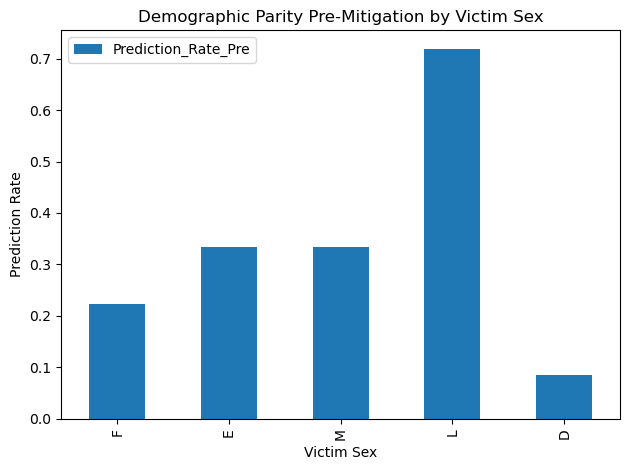

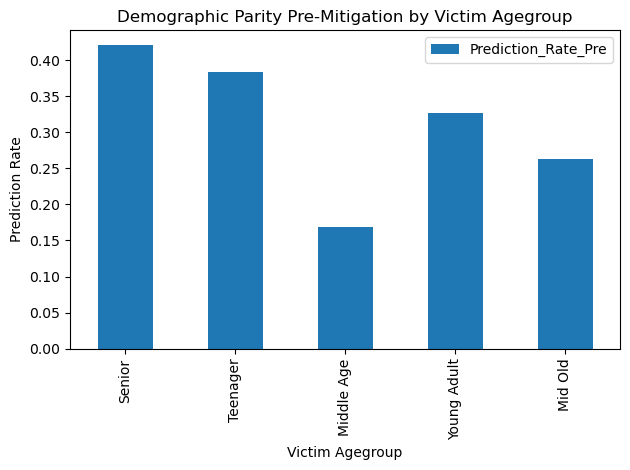

In [86]:
# Convert to Pandas DataFrames
dp_sex_pre_pd = dp_sex_pre.toPandas()
dp_age_pre_pd = dp_age_pre.toPandas()

# Plot Demographic Parity for Victim_Sex (Pre-Mitigation)
dp_sex_pre_pd.plot(
    kind='bar',
    x='Victim_Sex',
    y='Prediction_Rate_Pre',
    title='Demographic Parity Pre-Mitigation by Victim Sex'
)
plt.xlabel('Victim Sex')
plt.ylabel('Prediction Rate')
plt.tight_layout()
plt.show()

# Plot Demographic Parity for Victim_Agegroup (Pre-Mitigation)
dp_age_pre_pd.plot(
    kind='bar',
    x='Victim_Agegroup',
    y='Prediction_Rate_Pre',
    title='Demographic Parity Pre-Mitigation by Victim Agegroup'
)
plt.xlabel('Victim Agegroup')
plt.ylabel('Prediction Rate')
plt.tight_layout()
plt.show()

In [87]:
input_data = data.select(["features", "Offence_Level_index", "Victim_Sex", "Victim_Agegroup"])
input_data = input_data.withColumnRenamed("Offence_Level_index", "label")

# Split into training and test sets
train_data, test_data = input_data.randomSplit([0.7, 0.3], seed=42)

In [88]:
from pyspark.ml.classification import LogisticRegression

lg_model = LogisticRegression(
    labelCol="label",
    featuresCol="features",
    weightCol="weight",  # Use weights if applicable
    maxIter=100,
    regParam=0.1,
    elasticNetParam=0
)

lg_model = lg_model.fit(weighted_train_data)

In [89]:
# Make predictions on the test dataset
predictions = lg_model.transform(test_data)

# Evaluate the model
acc = accuracy_evaluator.evaluate(lg_pred)

print(f"Logistic Regression - Accuracy: {acc}")

# Include protected attributes for fairness analysis
predictions_with_attributes = predictions.select("prediction", "label", "Victim_Sex", "Victim_Agegroup")

Logistic Regression - Accuracy: 0.8515617376493653


In [90]:
predictions_with_attributes = predictions.select("prediction", "label", "Victim_Sex", "Victim_Agegroup")

In [91]:
# Demographic Parity for Victim_Sex (Post-Mitigation)
dp_sex_post = predictions_with_attributes.groupBy("Victim_Sex") \
    .agg(
        (count(when(col("prediction") == 1.0, True)) / count("*")).alias("Prediction_Rate_Post")
    )

# Demographic Parity for Victim_Agegroup (Post-Mitigation)
dp_age_post = predictions_with_attributes.groupBy("Victim_Agegroup") \
    .agg(
        (count(when(col("prediction") == 1.0, True)) / count("*")).alias("Prediction_Rate_Post")
    )

# Show post-mitigation metrics
dp_sex_post.show()
dp_age_post.show()

+----------+--------------------+
|Victim_Sex|Prediction_Rate_Post|
+----------+--------------------+
|         F|  0.3115037449587094|
|         E|   0.383236739322162|
|         M|  0.3932356065434459|
|         L|  0.6983273596176822|
|         D|  0.2894621237414117|
+----------+--------------------+



+---------------+--------------------+
|Victim_Agegroup|Prediction_Rate_Post|
+---------------+--------------------+
|         Senior| 0.42495374653098983|
|       Teenager| 0.42037803196235907|
|     Middle Age|  0.3373557114832558|
|    Young Adult|  0.3523597726711144|
|        Mid Old| 0.33088758861954737|
+---------------+--------------------+



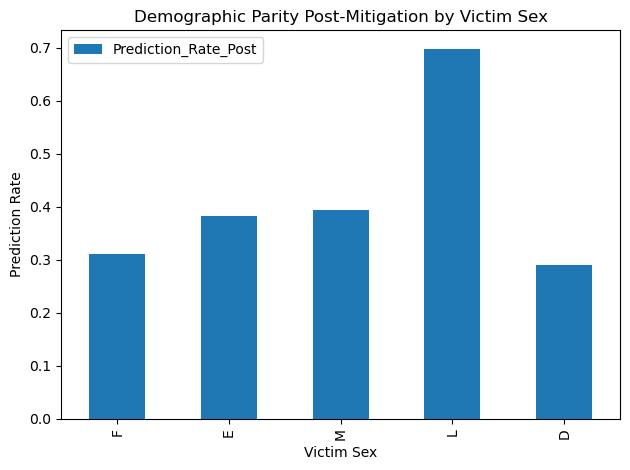

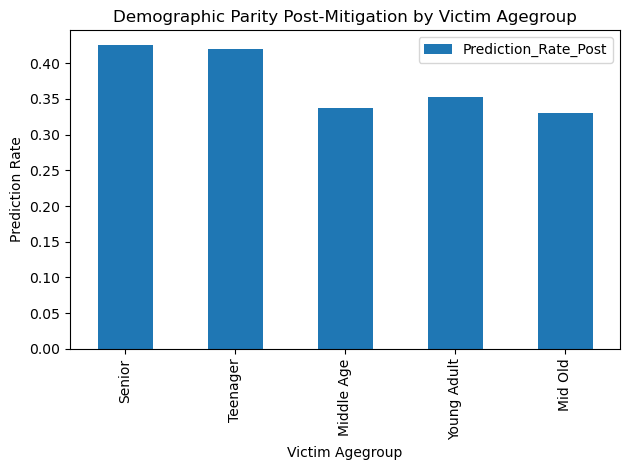

In [92]:
# Convert to Pandas DataFrames
dp_sex_post_pd = dp_sex_post.toPandas()
dp_age_post_pd = dp_age_post.toPandas()

# Plot Demographic Parity for Victim_Sex (Post-Mitigation)
dp_sex_post_pd.plot(
    kind='bar',
    x='Victim_Sex',
    y='Prediction_Rate_Post',
    title='Demographic Parity Post-Mitigation by Victim Sex'
)
plt.xlabel('Victim Sex')
plt.ylabel('Prediction Rate')
plt.tight_layout()
plt.show()

# Plot Demographic Parity for Victim_Agegroup (Post-Mitigation)
dp_age_post_pd.plot(
    kind='bar',
    x='Victim_Agegroup',
    y='Prediction_Rate_Post',
    title='Demographic Parity Post-Mitigation by Victim Agegroup'
)
plt.xlabel('Victim Agegroup')
plt.ylabel('Prediction Rate')
plt.tight_layout()
plt.show()

In [93]:
import pandas as pd

# Ensure both DataFrames have 'Victim_Sex' as a column
# Convert to Pandas if not already
dp_sex_pre_pd = dp_sex_pre.toPandas()
dp_sex_post_pd = dp_sex_post.toPandas()

# Merge on 'Victim_Sex'
dp_sex_comparison = pd.merge(dp_sex_pre_pd, dp_sex_post_pd, on='Victim_Sex')

# Display the merged DataFrame
print(dp_sex_comparison)

  Victim_Sex  Prediction_Rate_Pre  Prediction_Rate_Post
0          F             0.222699              0.311504
1          E             0.333067              0.383237
2          M             0.333379              0.393236
3          L             0.719065              0.698327
4          D             0.085199              0.289462


In [94]:
# Convert to Pandas if not already
dp_age_pre_pd = dp_age_pre.toPandas()
dp_age_post_pd = dp_age_post.toPandas()

# Merge on 'Victim_Agegroup'
dp_age_comparison = pd.merge(dp_age_pre_pd, dp_age_post_pd, on='Victim_Agegroup')

# Display the merged DataFrame
print(dp_age_comparison)

  Victim_Agegroup  Prediction_Rate_Pre  Prediction_Rate_Post
0          Senior             0.420097              0.424954
1        Teenager             0.383213              0.420378
2      Middle Age             0.169174              0.337356
3     Young Adult             0.327043              0.352360
4         Mid Old             0.263283              0.330888


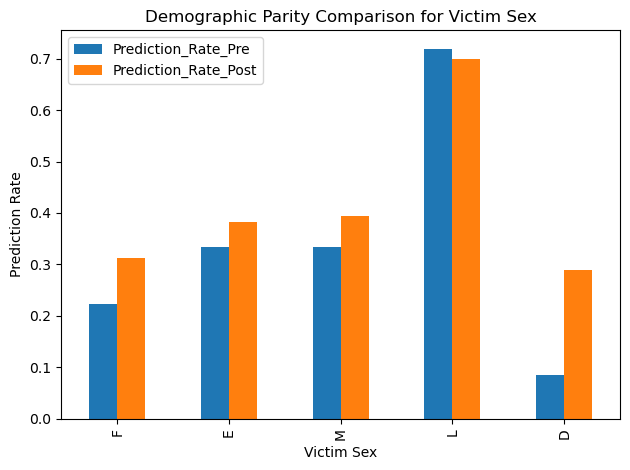

In [95]:
# Plot Demographic Parity Comparison for Victim_Sex
dp_sex_comparison.plot(
    kind='bar',
    x='Victim_Sex',
    y=['Prediction_Rate_Pre', 'Prediction_Rate_Post'],
    title='Demographic Parity Comparison for Victim Sex'
)
plt.xlabel('Victim Sex')
plt.ylabel('Prediction Rate')
plt.tight_layout()
plt.show()

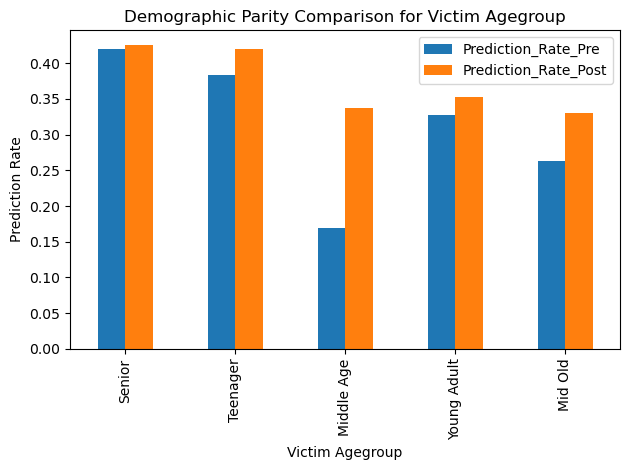

24/12/09 17:36:06 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2034859 ms exceeds timeout 120000 ms
24/12/09 17:36:06 WARN SparkContext: Killing executors is not supported by current scheduler.
24/12/09 17:36:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

24/12/09 17:50:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:50:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:50:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:51:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:51:10 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:51:20 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:51:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:51:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:51:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:52:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:52:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:52:20 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:52:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:52:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:52:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:53:00 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:53:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:53:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:53:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:53:40 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:53:50 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:54:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:54:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:54:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:54:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:54:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:54:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:55:00 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:55:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:55:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:55:30 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:55:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:55:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:56:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:56:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:56:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:56:30 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:56:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:56:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:57:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:57:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:57:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:57:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:57:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:57:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 17:58:00 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:58:10 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 17:58:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:18:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:18:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:18:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:18:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:18:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:18:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:19:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:19:10 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/12/09 18:19:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:19:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/12/09 18:19:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [96]:
# Plot Demographic Parity Comparison for Victim_Agegroup
dp_age_comparison.plot(
    kind='bar',
    x='Victim_Agegroup',
    y=['Prediction_Rate_Pre', 'Prediction_Rate_Post'],
    title='Demographic Parity Comparison for Victim Agegroup'
)
plt.xlabel('Victim Agegroup')
plt.ylabel('Prediction Rate')
plt.tight_layout()
plt.show()